In [196]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

# Implementation of Easy21

In [2]:
def draw_card():
    """
    Draw a card from the deck, with replacement.
    
    Returns a tuple of:
    - value: an integer between 1 and 10 (uniformly distributed)
    - color: 'red' (probability 1/3) or 'black' (probability 2/3)
    """
    min_val = 1
    max_val = 10
    prob_red = 1/3
    
    # Randomly choose value between min_val and max_val, inclusive
    value = np.random.randint(min_val, max_val + 1)
    
    # Choose 'red' color with probability prob_red, otherwise 'black'
    sample = np.random.rand()
    color = None
    if sample < prob_red:
        color = 'red'
    else:
        color = 'black'
    
    return (value, color)

In [6]:
def card_to_int(card):
    """
    Convert a card to its integer equivalent.
    If the card is black, then its value is taken as is.
    If the card is red, then its value is negated.
    
    Inputs:
    - card: a tuple of value and color
    
    Returns:
    - int_value: the integer value of the card
    """
    value, color = card
    
    int_value = None
    if color == 'black':
        int_value = value
    elif color == 'red':
        int_value = -value
    else:
        raise ValueError('Invalid color %s' % color)
    
    return int_value

In [12]:
def get_card():
    """
    Draw a card and get its integer value.
    
    Returns:
    - integer value of a randomly drawn card
    """
    return card_to_int(draw_card())

In [25]:
def check_card_sum(card_sum):
    """
    Check that the card sum is still valid (between 1 and 21, inclusive)
    
    Returns:
    - valid: True if the card sum is valid, False otherwise
    """
    min_val = 1
    max_val = 21
    return (card_sum >= min_val) & (card_sum <= max_val)

In [242]:
def step(state, action):
    """
    Take a single step in the game Easy21.
    
    Inputs:
    - state: state containing dealer's first card and player's sum, not 'terminal'
    - action: 'hit' or 'stick'
    
    Returns a tuple of:
    - next_state: sample of the next state, may be 'terminal'
    - reward: 1 for win, -1 for loss, 0 for draw
    """
    dealer_sum, player_sum = state
    
    if action == 'hit':
        # Draw another card, add its value to the sum
        player_sum += get_card()
        
        # If sum is not valid, end the game
        if not check_card_sum(player_sum):
            return ('terminal', -1)
    elif action == 'stick':
        # Dealer starts taking turns, sticks on sum >= 17, hits otherwise
        # During this process, does dealer go bust if sum < 1?
        while dealer_sum < 17:
            dealer_sum += get_card()
        
        # Check if dealer went bust
        if not check_card_sum(dealer_sum):
            return ('terminal', 1)
        
        # Check who has the largest sum
        if player_sum > dealer_sum:
            return ('terminal', 1) # win
        elif player_sum < dealer_sum:
            return ('terminal', -1) # loss
        else:
            return ('terminal', 0) # draw
    else:
        raise ValueError('Invalid action %s' % action)
    
    # Continue game, no intermediate reward
    return (dealer_sum, player_sum), 0

In [238]:
step((3, 10), 'hit')

((3, 14), 0)

In [239]:
step((3, 18), 'hit')

('terminal', -1)

In [247]:
step((3, 18), 'stick')

('terminal', 1)

# Monte-Carlo Control in Easy21
Apply Monte-Carlo control to determine the optimal value function.

For every episode, perform Monte-Carlo policy evaluation (one step) and epsilon-Greedy policy improvement.

## Monte-Carlo policy evaluation
For each state $S_t$ and action $A_t$ in the episode,

$$N(S_t, A_t) \leftarrow N(S_t, A_t) + 1$$

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t, A_t)}(G_t - Q(S_t, A_t))$$

## $\epsilon$-Greedy policy improvement
Within each episode, follow an $\epsilon$-greed exploration strategy with $\epsilon_t = N_0/(N_0 + N(s_t))$, where $N_0 = 100$ and $N(s)$ is the number of times that state $s$ has been visited.

With probability $\epsilon_t$, choose an action at random (for exploration). Otherwise, choose the action with greater action-value, $\underset{a}{\operatorname{argmax}} Q(s, a)$.

In [118]:
def run_episode(q):
    """
    Run an episode (to termination) of Easy21, following epsilon-greedy policy wrt value function.
    
    Inputs:
    - q: action-value function, matrix of size (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    
    Returns:
    - steps: list of the steps (state, action, reward, next state) taken in the episode
    """
    N, M, A = q.shape
    
    steps = []
    
    # At start of episode, dealer and player each draw one black card
    dealer_sum, player_sum = np.abs(get_card()), np.abs(get_card())
    state = (dealer_sum, player_sum)
    
    actions = ['hit', 'stick']
    
    N0 = 100 # initial count
    N_S = np.zeros((N, M)) # running count of states encountered
    
    while state != 'terminal':
        dsum, psum = state
        
        N_S[dsum-1, psum-1] += 1 # increment count for current state
        
        # Follow epsilon-greedy policy
        # calculate probability of choosing random action, for exploration
        eps = N0 / (N0 + N_S[dsum-1, psum-1])
        
        # sample random probability
        sample = np.random.rand()
        
        action = None
        if sample < eps:
            # Sample action randomly
            action = actions[np.random.randint(len(actions))]
        else:
            # Choose greedy action
            action = actions[np.argmax(q[dsum-1, psum-1])]
        
        new_state, reward = step(state, action)
        
        # Add step to the list of steps
        steps.append((state, action, reward, new_state))
        
        state = new_state
    
    return steps

In [119]:
q = np.zeros((10, 21, 2))
run_episode(q)

[((6, 4), 'stick', -1, 'terminal')]

In [77]:
q = np.zeros((10, 21, 2))
run_episode(q)

[((6, 3), 'hit', 0, (6, 9)), ((6, 9), 'stick', -1, 'terminal')]

In [79]:
q = np.random.rand(10, 21, 2)
run_episode(q)

[((2, 8), 'stick', -1, 'terminal')]

In [82]:
q = np.random.rand(10, 21, 2)
run_episode(q)

[((1, 1), 'hit', 0, (1, 2)),
 ((1, 2), 'hit', 0, (1, 5)),
 ((1, 5), 'hit', 0, (1, 10)),
 ((1, 10), 'hit', 0, (1, 16)),
 ((1, 16), 'hit', 0, (1, 9)),
 ((1, 9), 'stick', -1, 'terminal')]

In [108]:
q = np.random.rand(10, 21, 2)
t = 0
while True:
    t += 1
    steps = run_episode(q)
    _, _, reward, _ = steps[-1]
    if reward > 0:
        print('Iteration %d:' % t)
        print(steps)
        break

Iteration 2:
[((8, 1), 'hit', 0, (8, 2)), ((8, 2), 'hit', 0, (8, 3)), ((8, 3), 'hit', 0, (8, 2)), ((8, 2), 'hit', 0, (8, 7)), ((8, 7), 'hit', 0, (8, 14)), ((8, 14), 'hit', 0, (8, 19)), ((8, 19), 'stick', 1, 'terminal')]


In [244]:
def mc_control_easy21():
    """
    Apply Monte-Carlo control to Easy21.
    
    Returns:
    - q: optimal action-value function, shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    """
    N, M, A = 10, 21, 2

    actions = ['hit', 'stick']

    # Lookup table for action-value function
    q = np.zeros((N, M, A))

    N_SA = np.zeros((N, M, A)) # running count of <state, action> pairs encountered
    
    num_steps = 1000000

    for _ in range(num_steps):
        # Run an episode following epsilon-greedy policy
        steps = run_episode(q)

        # Since no discount, return for all steps is reward at end of episode
        _, _, Gt, _ = steps[-1]

        dq = np.zeros((N, M, A)) # store change in q

        # For each <state, action> pair, update action-value function
        for step_t in steps:
            state, action, _, _ = step_t
            dsum, psum = state

            # Increment count of <state, action> pair
            N_SA[dsum-1, psum-1, actions.index(action)] += 1

            # Calculate update for action-value function, will update at end of episode
            alpha = 1 / N_SA[dsum-1, psum-1, actions.index(action)]
            dq[dsum-1, psum-1, actions.index(action)] = alpha * (Gt - q[dsum-1, psum-1, actions.index(action)])
        
        # Update action-value function after all updates have been calculated
        q += dq
    
    return q

In [245]:
q = mc_control_easy21()

In [234]:
def plot_optimal_val_fn(q):
    """
    Plot optimal state-value function V* using optimal action-value function Q*.
    Specifically, V*(s) = max_a Q*(s, a)
    
    Inputs:
    - q: optimal action-value function, shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    """
    N, M, _ = q.shape
    v = np.zeros((N, M))
    
    n_vals = range(N)
    m_vals = range(M)
    
    for n in n_vals:
        for m in m_vals:
            v[n, m] = np.amax(q[n, m])
    
    nn, mm = np.meshgrid(n_vals, m_vals) # Not sure why it switches axes, need to transpose v to plot
    
    plt.figure(figsize=(8, 6))
    ax = plt.axes(projection='3d')
    ax.plot_surface(nn, mm, v.T, cmap='bwr')
    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Optimal state-value')

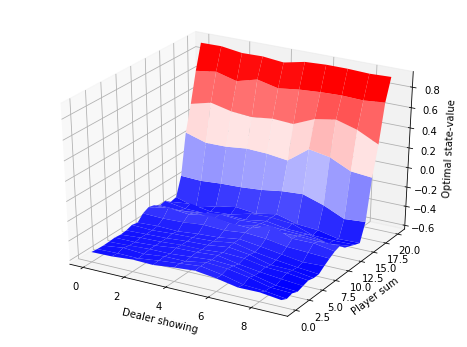

In [246]:
plot_optimal_val_fn(q)